<p style="text-align:center; font-family: Arial; font-size:1.5rem; color:lime; font-weight:bold;">Datos meteorológicos por minuto</p>

### Descripción
En esta guía, se abordará en detalle la implementación del algoritmo K-means en conjunto con un análisis de conglomerados para la construcción de un modelo climático. Se utilizarán datos de resolución minuto para este propósito. A pesar de la potencialidad de contar con un gran volumen de registros, nos enfocaremos en la creación de 12 grupos distintivos para una mayor comprensión y precisión en el modelado del clima

#### 1. Importar Librerias

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import datetime
import seaborn as sns
%matplotlib inline

#### 2. Leer el CSV y ver datos

In [7]:
data = pd.read_csv('databases/minuto.csv')

 La estación meteorológica está equipada con sensores que capturan mediciones relacionadas con el clima, como la temperatura del aire, la presión del aire y la humedad relativa. Los datos se recopilaron durante un período de tres años, de septiembre de 2011 a septiembre de 2014, para garantizar que se capturan datos suficientes para diferentes estaciones y condiciones climáticas.

Cada fila en ** minuto.csv ** contiene datos meteorológicos capturados para un intervalo de un minuto. Cada fila, o muestra, consta de las siguientes variables:

* **rowID:** 	Llave única
* **hpwren_timestamp:**	timestamp de la medida	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** presión atmosférica	(*Hectopascales*)
* **air_temp:**	Temperatura del aire	(*Grados Fahrenheit*)
* **avg_wind_direction:**	direccion del viento promedio durante el minuto previo al timestamp
* **avg_wind_speed:**	velocidad del viento promedio durante el minuto previo al timestamp (metros por segundo)
* **max_wind_direction:**	Direccion máxima del viento 
* **max_wind_speed:**	Velocidad máxima del viento
* **min_wind_direction:**	Dirección mínima del viento
* **min_wind_speed:**	Velocidad mínima del viento
* **rain_accumulation:**	Acumulación de lluvia al timestamp
* **rain_duration:**	duración de la lluvia
* **relative_humidity:**	humedad relativa medida en el timestamp

In [8]:
data.shape

(1587257, 13)

In [9]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


#### 3. Simplificacion del Dataset

In [10]:
sampled_df = data[(data['rowID'] % 10)  == 0]
sampled_df.shape

(158726, 13)

#### 4. Datos Estadisticos

In [11]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


##### 5. Limpiar de Dataset

In [15]:
raind= sampled_df[sampled_df['rain_duration'] == 0].shape
raina= sampled_df[sampled_df['rain_accumulation'] == 0].shape
minwind= sampled_df[sampled_df['min_wind_speed'] == 0].shape

print('rain duration tiene valores en cero de: ', raind)
print('rain acumulation tiene valores en cero de: ', raina)
print('min_wind_speed tiene valores en cero de: ', minwind)

rain duration tiene valores en cero de:  (157237, 13)
rain acumulation tiene valores en cero de:  (157812, 13)
min_wind_speed tiene valores en cero de:  (1311, 13)


<font color=green><b>Con esto podemos ver que tanto "rain_accumulation" como "rain_duration" tienen demasiados valores vacíos o nulos, lo cual es más factible eliminarlos que reemplazarlos por una media.</b></font>


In [17]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [18]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

##### ¿Cuantas filas se perdieron?

In [19]:
rows_before - rows_after

46

In [20]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

##### 6. Seleccionar features

In [24]:
features = ['air_temp', 'avg_wind_direction', 'avg_wind_speed','relative_humidity']

C:\Users\ferna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ferna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ferna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ferna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

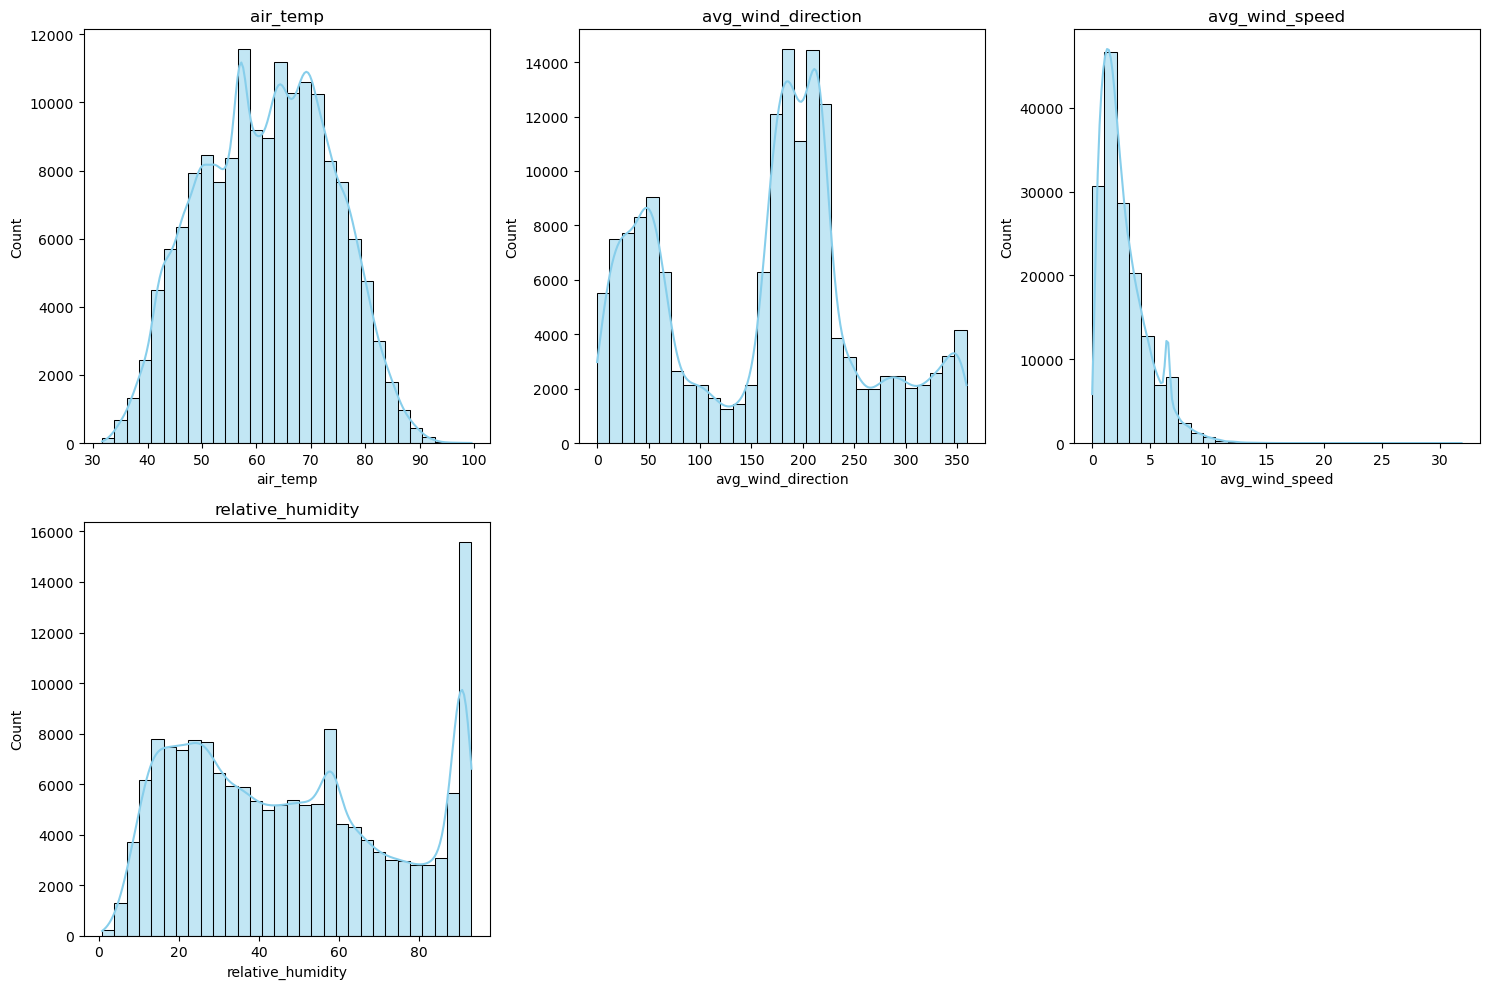

In [25]:
# Selecciona las características para visualizar
features_to_plot = ['air_temp', 'avg_wind_direction', 'avg_wind_speed', 'relative_humidity']

# Configura el tamaño de la figura y el número de columnas para las subtramas
plt.figure(figsize=(15, 10))
num_cols = 3

# Crea subtramas para cada característica
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot((len(features_to_plot) - 1) // num_cols + 1, num_cols, i)
    sns.histplot(sampled_df[feature], kde=True, color='skyblue', bins=30)
    plt.title(feature)

plt.tight_layout()
plt.show()

In [26]:
select_df = sampled_df[features]

In [27]:
select_df.columns

Index(['air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'relative_humidity'],
      dtype='object')

##### 7. Preparar los datos

In [28]:
X = StandardScaler().fit_transform(select_df)
X

array([[ 0.24544455, -0.68385323, -0.76555283,  0.49233835],
       [ 0.03247142, -0.19055941, -0.76555283, -0.34710804],
       [ 0.12374562, -0.65236639, -0.37675365,  0.40839371],
       ...,
       [ 1.15818654,  1.90856325, -0.66835304,  0.01538018],
       [ 1.12776181,  2.06599745, -0.71695294, -0.04948614],
       [ 1.09733708, -1.63895404, -0.61975314, -0.05711747]])

##### 8. Implementando KMEANS

In [32]:
kmeans = KMeans(n_clusters=12, n_init=10)
#Ajustamos el modelo
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=12, n_init=10)


In [33]:
centers = model.cluster_centers_
centers

array([[ 1.20315165,  1.57463478, -0.61050165, -0.86496865],
       [-0.25224387, -1.12858856,  2.04369823, -1.14675225],
       [-0.81087033, -1.17457709, -0.58543852,  0.95879201],
       [ 0.10787708,  0.2106135 , -0.40122658,  0.3680599 ],
       [-0.29062316,  0.44071791,  1.38544666,  0.31328158],
       [ 0.80144972,  0.26917114, -0.63981391, -0.79117675],
       [ 0.9670449 ,  0.4247676 ,  0.64223058, -0.31778966],
       [ 1.03582345, -1.29975503, -0.53750342, -0.73152229],
       [-0.34269423,  1.49715571, -0.64838797, -0.2431992 ],
       [-1.4238634 ,  0.37089738,  1.63884251,  1.50762145],
       [-1.19824508,  0.60536395, -0.28072174,  1.40275077],
       [-0.27635344, -1.15419558, -0.27058064, -0.85155419]])

##### 9. Se grafican para verificar

In [35]:
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')


	Z = [np.append(A, index) for index, A in enumerate(centers)]

	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [46]:
def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.style.use("dark_background")
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [37]:
P = pd_centers(features, centers)
P

,air_temp,avg_wind_direction,avg_wind_speed,relative_humidity,prediction
0,1.203152,1.574635,-0.610502,-0.864969,0
1,-0.252244,-1.128589,2.043698,-1.146752,1
2,-0.810870,-1.174577,-0.585439,0.958792,2
3,0.107877,0.210614,-0.401227,0.368060,3
4,-0.290623,0.440718,1.385447,0.313282,4
5,0.801450,0.269171,-0.639814,-0.791177,5
6,0.967045,0.424768,0.642231,-0.317790,6
7,1.035823,-1.299755,-0.537503,-0.731522,7
8,-0.342694,1.497156,-0.648388,-0.243199,8
9,-1.423863,0.370897,1.638843,1.507621,9


<font color=#FFA07A size=+2><b>Gráfica los días secos</b> 🍂</font>


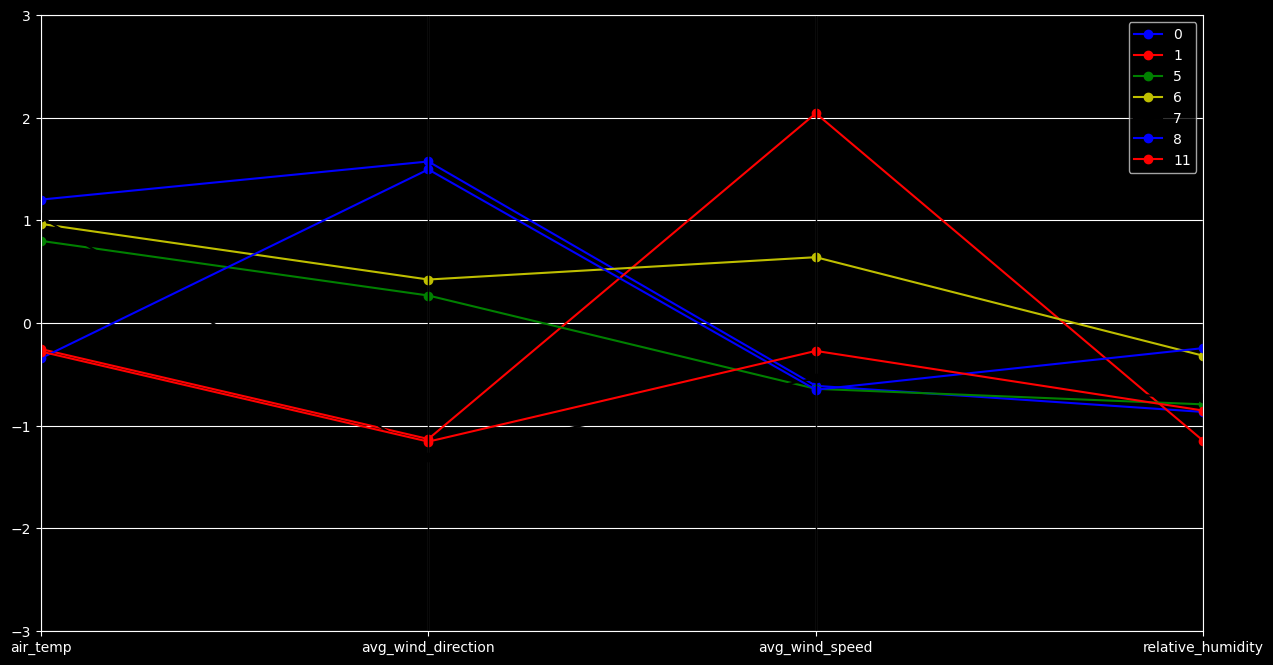

In [52]:
parallel_plot(P[P['relative_humidity']< -0.11])

<font color=#FFD700 size=+2><b>Gráfica los días templados</b> ☀️</font>


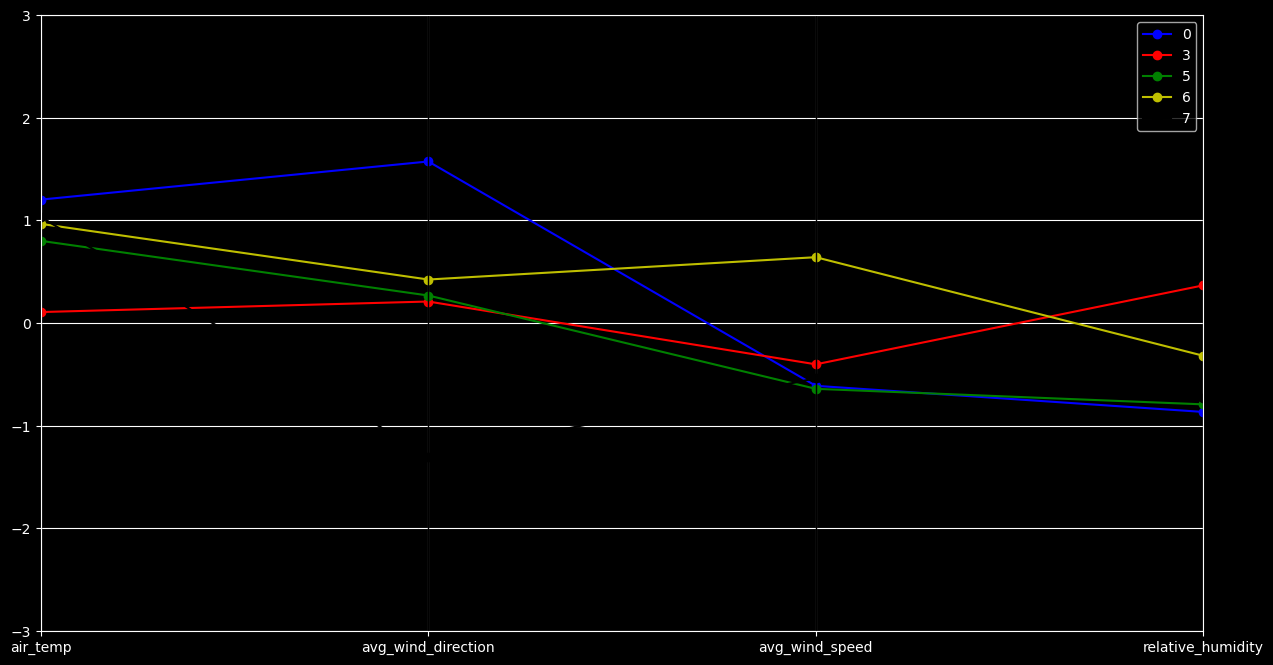

In [53]:
parallel_plot(P[P['air_temp'] > -0.11])

 <font color=#87CEEB size=+2><b>Gráfica los días fríos</b> ❄️</font>

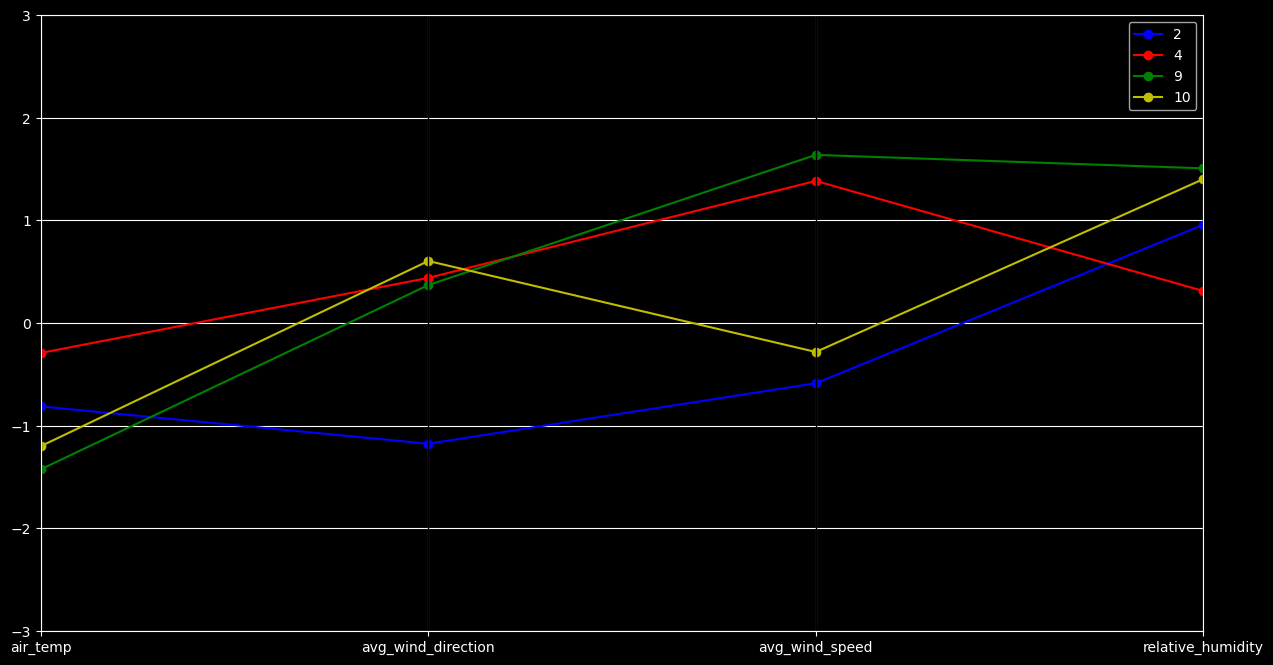

In [55]:
parallel_plot(P[(P['relative_humidity'] > -0.11) & (P['air_temp'] < -0.11)])

In [57]:
# Calculamos la inercia del modelo
inercia = model.inertia_
print("Inercia del modelo:", inercia)

Inercia del modelo: 139376.0784880212
